<a href="https://www.kaggle.com/blacksheep2105/gdsc-task-round?scriptVersionId=85556202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Death Event recognizer using SMOTE

## Importing Project Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

import sklearn
from sklearn.metrics import confusion_matrix


import os
import tempfile
import seaborn as sns

## Data pre-processing

In [2]:
data = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
for i in data.columns:
    print(data[i].isnull().value_counts())

False    299
Name: age, dtype: int64
False    299
Name: anaemia, dtype: int64
False    299
Name: creatinine_phosphokinase, dtype: int64
False    299
Name: diabetes, dtype: int64
False    299
Name: ejection_fraction, dtype: int64
False    299
Name: high_blood_pressure, dtype: int64
False    299
Name: platelets, dtype: int64
False    299
Name: serum_creatinine, dtype: int64
False    299
Name: serum_sodium, dtype: int64
False    299
Name: sex, dtype: int64
False    299
Name: smoking, dtype: int64
False    299
Name: time, dtype: int64
False    299
Name: DEATH_EVENT, dtype: int64


In [4]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


### Pre-processing steps
1. Remove unwanted attributes
2. Take logarithmic value of some attributes to reduce the variance
3. Standardize the data for better model performance

In [5]:
def normalize_continuous_vals(data1, exclude, logrized_vals, pop, thresh=0.001):
    
    for i in pop:
        data1 = data1.drop(i, axis=1)
    
    for i in logrized_vals:
        data1[i] = np.log(data1[i]) + thresh
    
    for i in data1.columns:
        if i in exclude:
            continue
        else:
            data1[i] = (data1[i] - data1[i].mean()) / data1[i].std()
    
    return data1

n_data = normalize_continuous_vals(data, ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'], 
                                 ['creatinine_phosphokinase', 'platelets', 'serum_sodium'], ['time'])

In [6]:
(np.log(data['serum_sodium']) + 0.001 - (np.log(data['serum_sodium']) + 0.001 ).mean()) / (np.log(data['serum_sodium']) + 0.001 ).std()
n_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,1.190949,0,0.622840,0,-1.527998,1,0.192505,0.489237,-1.492431,1,0,1
1,-0.490457,0,2.917541,0,-0.007065,0,0.177009,-0.284076,-0.123054,1,0,1
2,0.350246,0,-0.596145,0,-1.527998,0,-1.034456,-0.090748,-1.726790,1,1,1
3,-0.910808,1,-0.837741,0,-1.527998,0,-0.387457,0.489237,0.099286,1,0,1
4,0.350246,1,-0.515429,1,-1.527998,0,0.716640,1.262550,-4.950568,0,0,1


In [7]:
X = tf.cast(np.array(n_data.drop(['DEATH_EVENT'], axis=1)), tf.float32)
y = tf.cast(np.array(n_data['DEATH_EVENT']), tf.int32)
X.shape


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

TensorShape([299, 11])

In [8]:
def input_pipeline(X, y, batch_size, shuffle_buffer, split_ratio):
    
    """
    args:- 
        X: Feature values -> [tf.Tensor, np.array]
        y: Corresponding Lables -> [tf.Tensor, np.array]
        batch_size: batch_size for training
        split_ratio: percentage of data to split into training and validation datasets
        shuffle_buffer: buffer to consider while shuffling
    
    return:-
        train_ds: prefetched training dataset
        eval_ds: prefetched validation dataset
    """
    
    split_index = len(X) - int(len(X) * split_ratio)
    
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(shuffle_buffer)
    train_ds = ds.take(split_index).batch(batch_size)
    eval_ds = ds.skip(split_index).batch(batch_size)
    
    return (train_ds.prefetch(1), eval_ds.prefetch(1))

Now let us consider the distribution of the classes

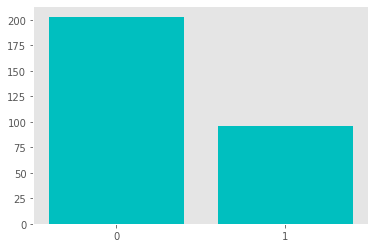

In [9]:
style.use('ggplot')
plt.bar(['0', '1'], [n for n in data['DEATH_EVENT'].value_counts()], color='c')
plt.grid(False)
plt.show()

As seen in the graph, the data distribution is skewed, for resloving this issue we will use a method of oversampling known as '`Synthetic Minority Oversampling Technique (SMOTE)`

In [10]:
neg_samples, pos_samples = [n for n in data['DEATH_EVENT'].value_counts()]
initial_bias = tf.math.log(pos_samples / neg_samples)
initial_bias

<tf.Tensor: shape=(), dtype=float32, numpy=-0.7488578>

In [11]:
def build_model(metrics, name, out_bias=None):
    if out_bias is not None:
        out_bias = tf.keras.initializers.Constant(out_bias)
        
    
    inputs = layers.Input(shape=(11,))
    x = layers.Dense(2048, activation='relu')(inputs)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid', bias_initializer=out_bias)(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name=name)
    
    model.compile(metrics = metrics, loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam())
    
    return model

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]

### In order to see the effect of (SMOTE) we shall now lay a basline upon which we will try to improve!

This model is a raw model without considering the data skew, let's analyze it's performance

In [12]:
raw_model = build_model(METRICS, 'raw_model')
raw_model.summary()

Model: "raw_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              24576     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51

This model has it's bias adjusted according to the ratio of the skew

In [13]:
baseline_model = build_model(METRICS, 'baseline_model', initial_bias)
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              24576     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)              

In [14]:
train_ds, eval_ds = input_pipeline(X, y, 2048, 299, 0.2)

In [15]:
raw_model.evaluate(train_ds)

2022-01-18 18:13:22.362093: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 1s 1s/step - loss: 0.6332 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 163.0000 - fn: 77.0000 - accuracy: 0.6792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4865 - prc: 0.3086


[0.6332244873046875,
 0.0,
 0.0,
 163.0,
 77.0,
 0.6791666746139526,
 0.0,
 0.0,
 0.48649510741233826,
 0.3085893392562866]

In [16]:
baseline_model.evaluate(train_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.6291 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 327.0000 - fn: 153.0000 - accuracy: 0.6812 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4665 - prc: 0.2906


[0.6290900111198425,
 0.0,
 0.0,
 327.0,
 153.0,
 0.6812499761581421,
 0.0,
 0.0,
 0.46647077798843384,
 0.2905975580215454]

As can be seen from above two cases, only changing bias of the model according to the skew ratio, loss has been reduced to almost half of it's original value

In [17]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
baseline_model.save_weights(initial_weights)

### Performance of a baseline model

In [18]:
baseline_model = build_model(METRICS, 'baseline_model')
baseline_model.load_weights(initial_weights)
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_recall', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
baseline_history = baseline_model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6425 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 486.0000 - fn: 234.0000 - accuracy: 0.6750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4599 - prc: 0.2994 - val_loss: 0.5948 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 35.0000 - val_fn: 16.0000 - val_accuracy: 0.6780 - val_precision: 0.6250 - val_recall: 0.2381 - val_auc: 0.7600 - val_prc: 0.5989
Epoch 2/100
1/1 [==============================] - 0s 68ms/step - loss: 0.5617 - tp: 21.0000 - fp: 7.0000 - tn: 156.0000 - fn: 56.0000 - accuracy: 0.7375 - precision: 0.7500 - recall: 0.2727 - auc: 0.8242 - prc: 0.6644 - val_loss: 0.5320 - val_tp: 6.0000 - val_fp: 3.0000 - val_tn: 36.0000 - val_fn: 14.0000 - val_accuracy: 0.7119 - val_precision: 0.6667 - val_recall: 0.3000 - val_auc: 0.7846 - val_prc: 0.6476
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.5300 - tp: 29.0000 - fp: 17.0000 - tn: 147.0000 - fn: 47.0000 - accuracy: 0.7333 - preci

In [19]:
def plot_metrics(history):
    plt.figure(figsize=(15, 10))
    metrics = ['loss', 'prc', 'precision', 'recall']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

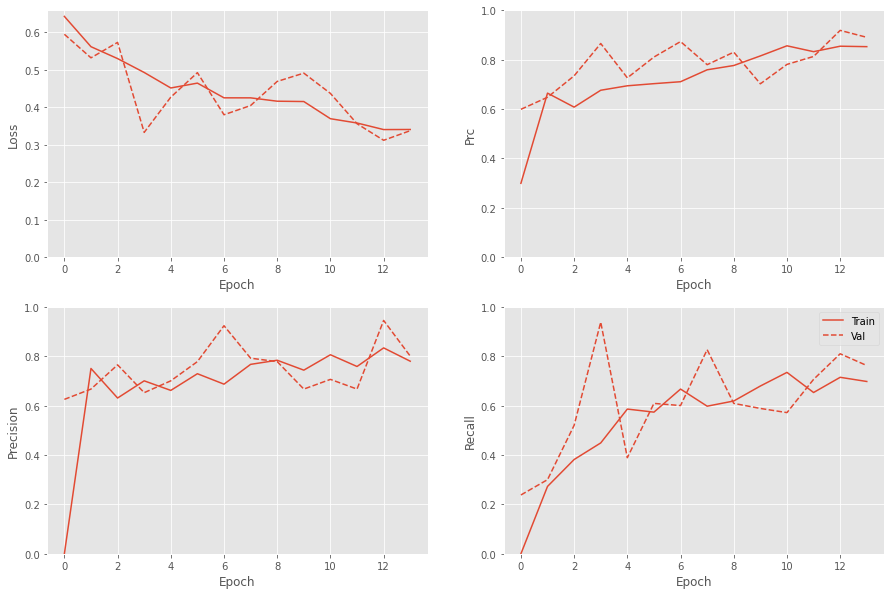

In [20]:
plot_metrics(baseline_history)

In [21]:
def plot_confusion_matrix(labels, predictions, p=0.5):
    
    for i in labels:
        labels = i[1]
    
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

1/1 [==============================] - 0s 19ms/step - loss: 0.3815 - tp: 9.0000 - fp: 6.0000 - tn: 40.0000 - fn: 4.0000 - accuracy: 0.8305 - precision: 0.6000 - recall: 0.6923 - auc: 0.8746 - prc: 0.7574
loss :  0.38151565194129944
tp :  9.0
fp :  6.0
tn :  40.0
fn :  4.0
accuracy :  0.8305084705352783
precision :  0.6000000238418579
recall :  0.692307710647583
auc :  0.8745819330215454
prc :  0.7573544979095459

Legitimate Transactions Detected (True Negatives):  28
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  7
Total Fraudulent Transactions:  20


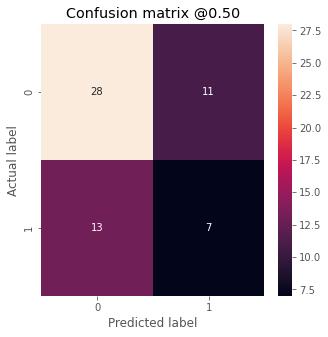

In [22]:
baseline_results = baseline_model.evaluate(eval_ds)
for name, value in zip(baseline_model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_confusion_matrix(eval_ds, baseline_model.predict(eval_ds))

# Performance of a weighted model

In [23]:
total = neg_samples + pos_samples
weight_for_0 = (1 / neg_samples) * (total / 2.0)
weight_for_1 = (1 / pos_samples) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.56


In [24]:
weighted_model = build_model(METRICS, 'baseline_model')
weighted_model.load_weights(initial_weights)
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)
weighted_history = weighted_model.fit(train_ds, validation_data=eval_ds, epochs=100, callbacks=[early_stopping],
                                       class_weight=class_weight)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7191 - tp: 9.0000 - fp: 6.0000 - tn: 209.0000 - fn: 75.0000 - accuracy: 0.7291 - precision: 0.6000 - recall: 0.1071 - auc: 0.5327 - prc: 0.3622 - val_loss: 0.5893 - val_tp: 23.0000 - val_fp: 10.0000 - val_tn: 25.0000 - val_fn: 1.0000 - val_accuracy: 0.8136 - val_precision: 0.6970 - val_recall: 0.9583 - val_auc: 0.9060 - val_prc: 0.8577
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 0.6215 - tp: 66.0000 - fp: 69.0000 - tn: 93.0000 - fn: 12.0000 - accuracy: 0.6625 - precision: 0.4889 - recall: 0.8462 - auc: 0.7951 - prc: 0.6121 - val_loss: 0.6028 - val_tp: 21.0000 - val_fp: 16.0000 - val_tn: 21.0000 - val_fn: 1.0000 - val_accuracy: 0.7119 - val_precision: 0.5676 - val_recall: 0.9545 - val_auc: 0.8882 - val_prc: 0.7500
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.5905 - tp: 70.0000 - fp: 86.0000 - tn: 78.0000 - fn: 6.0000 - accuracy: 0.6167 - precision: 0.4487 - re

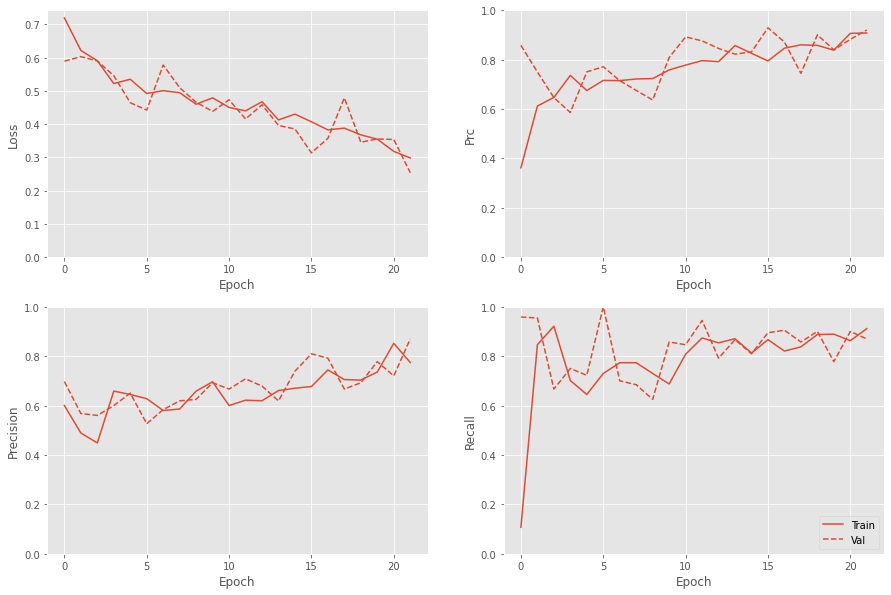

In [25]:
plot_metrics(weighted_history)

1/1 [==============================] - 0s 30ms/step - loss: 0.6163 - tp: 24.0000 - fp: 17.0000 - tn: 17.0000 - fn: 1.0000 - accuracy: 0.6949 - precision: 0.5854 - recall: 0.9600 - auc: 0.8553 - prc: 0.7213
loss :  0.6163293719291687
tp :  24.0
fp :  17.0
tn :  17.0
fn :  1.0
accuracy :  0.694915235042572
precision :  0.5853658318519592
recall :  0.9599999785423279
auc :  0.8552941083908081
prc :  0.7213377356529236

Legitimate Transactions Detected (True Negatives):  18
Legitimate Transactions Incorrectly Detected (False Positives):  22
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  12
Total Fraudulent Transactions:  19


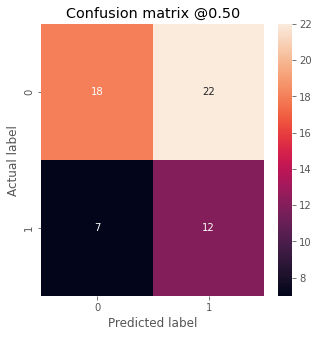

In [26]:
weighted_results = weighted_model.evaluate(eval_ds)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_confusion_matrix(eval_ds, weighted_model.predict(eval_ds))

## SMOTE

In [27]:
li = []
for i in train_ds:
    li.append(i[0])
    li.append(i[1])

    
li

[<tf.Tensor: shape=(240, 11), dtype=float32, numpy=
 array([[-0.9108085 ,  0.        ,  0.22116677, ..., -0.12305427,
          1.        ,  0.        ],
        [-0.65859765,  1.        ,  0.7943435 , ...,  0.09928646,
          1.        ,  1.        ],
        [-0.23824619,  0.        , -0.60830337, ...,  1.1871941 ,
          0.        ,  0.        ],
        ...,
        [-1.5833708 ,  0.        ,  2.554784  , ...,  0.7566993 ,
          1.        ,  1.        ],
        [-0.07010562,  0.        ,  0.62284   , ..., -0.57268286,
          1.        ,  0.        ],
        [-0.9108085 ,  0.        ,  0.62284   , ..., -0.34703588,
          1.        ,  1.        ]], dtype=float32)>,
 <tf.Tensor: shape=(240,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0

In [28]:
bool_train_labels = li[1] != 0

In [29]:
len(bool_train_labels) - np.sum(bool_train_labels)

160

In [30]:
for i in train_ds:
    print(i[0])

tf.Tensor(
[[ 2.788284    0.          0.62284    ... -0.57268286  1.
   0.        ]
 [ 0.18210524  1.         -0.9036778  ... -0.12305427  1.
   1.        ]
 [ 0.3502458   0.          0.62284    ... -0.12305427  1.
   1.        ]
 ...
 [-0.9108085   1.         -0.47242063 ...  0.09928646  1.
   0.        ]
 [-0.49045706  0.          1.6278489  ...  0.53914016  0.
   0.        ]
 [-0.49045706  0.         -0.85376865 ...  0.53914016  1.
   1.        ]], shape=(240, 11), dtype=float32)


In [31]:
pos_features = li[0][bool_train_labels]
neg_features = li[0][~bool_train_labels]

pos_labels = li[1][bool_train_labels]
neg_labels = li[1][~bool_train_labels]

In [32]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [33]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resmapled_ds = resampled_ds.shuffle(BUFFER_SIZE)
resampled_ds = resampled_ds.batch(1024).prefetch(2)

Features:
 [ 2.8723543   1.          0.22593161  0.         -0.68303514  0.
  1.572881    0.5859009  -1.029073    1.          0.        ]

Label:  1


In [34]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49609375


In [35]:
resampled_steps_per_epoch = np.ceil(2.0*164/64)
resampled_steps_per_epoch

6.0

In [36]:
resampled_model = build_model(METRICS, 'resampled_model')
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(resampled_ds, validation_data=eval_ds, epochs=1000, callbacks=[early_stopping],
                                       steps_per_epoch=resampled_steps_per_epoch)

Epoch 1/1000
6/6 [==============================] - 4s 360ms/step - loss: 0.5634 - tp: 2340.0000 - fp: 1205.0000 - tn: 1947.0000 - fn: 711.0000 - accuracy: 0.6911 - precision: 0.6601 - recall: 0.7670 - auc: 0.7783 - prc: 0.7793 - val_loss: 0.4751 - val_tp: 16.0000 - val_fp: 11.0000 - val_tn: 29.0000 - val_fn: 3.0000 - val_accuracy: 0.7627 - val_precision: 0.5926 - val_recall: 0.8421 - val_auc: 0.8895 - val_prc: 0.8374
Epoch 2/1000
6/6 [==============================] - 1s 158ms/step - loss: 0.4091 - tp: 2608.0000 - fp: 604.0000 - tn: 2448.0000 - fn: 484.0000 - accuracy: 0.8229 - precision: 0.8120 - recall: 0.8435 - auc: 0.9009 - prc: 0.8982 - val_loss: 0.4101 - val_tp: 13.0000 - val_fp: 9.0000 - val_tn: 34.0000 - val_fn: 3.0000 - val_accuracy: 0.7966 - val_precision: 0.5909 - val_recall: 0.8125 - val_auc: 0.8961 - val_prc: 0.8256
Epoch 3/1000
6/6 [==============================] - 1s 155ms/step - loss: 0.2563 - tp: 2883.0000 - fp: 349.0000 - tn: 2708.0000 - fn: 204.0000 - accuracy: 0.9

In [37]:
resampled_model.evaluate(eval_ds)

1/1 [==============================] - 0s 19ms/step - loss: 0.3715 - tp: 15.0000 - fp: 4.0000 - tn: 39.0000 - fn: 1.0000 - accuracy: 0.9153 - precision: 0.7895 - recall: 0.9375 - auc: 0.9695 - prc: 0.8723


[0.3714723289012909,
 15.0,
 4.0,
 39.0,
 1.0,
 0.9152542352676392,
 0.7894737124443054,
 0.9375,
 0.9694766998291016,
 0.8722608685493469]

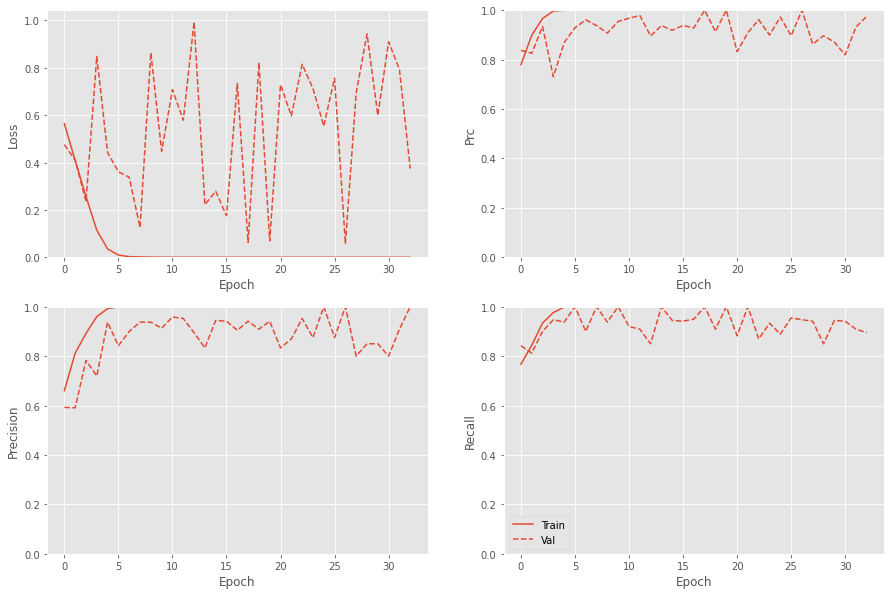

In [38]:
plot_metrics(resampled_history)

1/1 [==============================] - 0s 20ms/step - loss: 1.3550 - tp: 17.0000 - fp: 3.0000 - tn: 36.0000 - fn: 3.0000 - accuracy: 0.8983 - precision: 0.8500 - recall: 0.8500 - auc: 0.9064 - prc: 0.8089
loss :  1.3550176620483398
tp :  17.0
fp :  3.0
tn :  36.0
fn :  3.0
accuracy :  0.8983050584793091
precision :  0.8500000238418579
recall :  0.8500000238418579
auc :  0.9064102172851562
prc :  0.8088981509208679

Legitimate Transactions Detected (True Negatives):  24
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  8
Total Fraudulent Transactions:  19


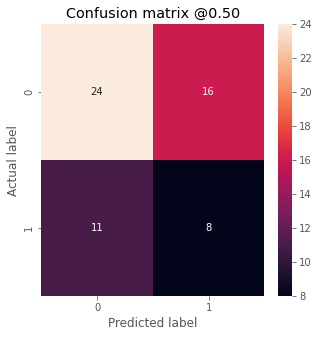

In [39]:
resampled_results = resampled_model.evaluate(eval_ds)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_confusion_matrix(eval_ds, resampled_model.predict(eval_ds))

# SMOTE gives the best results seen so far, hence by using this technique optimizing recall score is possible even for a small dataset!